In [14]:
import itertools
import operator
import sys
import os
import numpy as np
sys.path.append("../src")
from glob import glob
import pandas as pd
import json
from neuraldb.dataset.base_reader import NeuralDatabaseDatasetReader
from neuraldb.dataset.generators.v0_4_database_reader import V4DatabaseSpecificReader
from matplotlib import pyplot as plt

In [3]:
search_root = "/checkpoint/jth/job_staging/neuraldb_expts/experiment=tfidf_fusion"
checkpoint_name = "metrics.json"
files = glob("{}*/**/{}".format(search_root,checkpoint_name), recursive=True)


print(len(files))

144


In [9]:
def expand(idx,chunk):

  #elif idx == 1:
  #  return ["experiment={}".format(chunk)]
  if chunk.startswith("seed-"):
    return ["seed={}".format(chunk.replace("seed-",""))]
  elif "," in chunk:
    return chunk.split(",")
  elif "=" in chunk:
    return [chunk]
  return []

experiments = []
for file in files:
    chunks = file.replace(search_root,"").split("/")
    chunks = itertools.chain(*[expand(idx, chunk) for idx, chunk in enumerate(chunks)])

    data = {k:v for k,v in (chunk.split("=") for chunk in chunks)}
    data["file"] = file
    data['dir'] = os.path.dirname(file)
    data["filter_size"] = int(data["filter_size"])
    data["lr"] = float(data["lr"])
    experiments.append(data)

In [10]:
for experiment in experiments:
    with open(experiment['file']) as f:
        metrics = json.load(f)

    epoch_em = [epoch["EM"] for epoch in metrics["validation"]]

    best_epoch_num = np.argmax(epoch_em)
    metrics = {"best_validation_epoch": metrics["validation"][best_epoch_num]["epoch"],
       "best_validation_em": metrics["validation"][best_epoch_num]["EM"],
       "best_validation_loss": metrics["validation"][best_epoch_num]["avg_val_loss"]
    }

    experiment.update(metrics)

In [18]:
results = pd.DataFrame(experiments).fillna(0)
cols = {col:[np.mean, np.std] for col in filter(lambda col: col == "EM" or col.startswith("breakdown_"),results.columns)}
breakdown = pd.pivot_table(results, index=["model","context","version","lr"],columns=["filter_size"])
print(cols)
breakdown

{}


best_validation_em                      \
filter_size                                     1         2         4    
model   context version lr                                               
t5-base 100     v0.2    0.00006           0.898149  0.911542  0.903751   
                        0.00008           0.900626  0.914803  0.905171   
                        0.00010           0.898171  0.910852  0.902911   
                        0.00020           0.898854  0.912937  0.900775   
                        0.00050           0.893269  0.857725  0.853314   
                        0.00080           0.886548  0.847199  0.845736   
                        0.00100           0.842858  0.742509  0.767730   
                        0.00200           0.745070  0.686244  0.669574   
                v0.4    0.00006           0.813035  0.792053  0.783716   
                        0.00008           0.814397  0.791086  0.782142   
                        0.00010           0.813578  0.791335  0.783738   
                        0.00020           0.813181  0.783607  0.779672   
                        0.00050           0.805368  0.781711  0.771872   
                        0.00080           0.802130  0.769070  0.751362   
                        0.00100           0.679770  0.633373  0.572194   
                        0.00200           0.610507  0.522450  0.513990   

                                                                         \
filter_size                            6         8         12        16   
model   context version lr                                                
t5-base 100     v0.2    0.00006  0.900077  0.899073  0.869274  0.858130   
                        0.00008  0.898297  0.894764  0.877189  0.860250   
                        0.00010  0.899230  0.896836  0.867770  0.859965   
                        0.00020  0.894451  0.894363  0.857889  0.857250   
                        0.00050  0.889192  0.882149  0.853140  0.854443   
                        0.00080  0.839134  0.808476  0.831052  0.833770   
                        0.00100  0.766029  0.689288  0.687750  0.720332   
                        0.00200  0.654406  0.626983  0.645898  0.646847   
                v0.4    0.00006  0.781663  0.784237  0.787374  0.787831   
                        0.00008  0.783343  0.785883  0.789863  0.784275   
                        0.00010  0.781311  0.788681  0.787298  0.783671   
                        0.00020  0.776352  0.781428  0.784909  0.776078   
                        0.00050  0.770060  0.775222  0.777234  0.775056   
                        0.00080  0.641541  0.724365  0.763774  0.645519   
                        0.00100  0.581072  0.588485  0.542199  0.626522   
                        0.00200  0.497814  0.520407  0.471041  0.474600   

                                                    best_validation_epoch  \
filter_size                            24        32                    1    
model   context version lr                                                  
t5-base 100     v0.2    0.00006  0.857633  0.858633                    17   
                        0.00008  0.859366  0.860450                    18   
                        0.00010  0.859873  0.861683                    13   
                        0.00020  0.861776  0.860077                    13   
                        0.00050  0.851014  0.852592                    12   
                        0.00080  0.844320  0.802968                    19   
                        0.00100  0.738039  0.687713                    18   
                        0.00200  0.595700  0.575933                    19   
                v0.4    0.00006  0.783221  0.782844                    11   
                        0.00008  0.785948  0.787644                     4   
                        0.00010  0.781994  0.779452                    11   
                        0.00020  0.777703  0.782505                    11   
                        0.00050  0.773690  0

In [16]:
for col in breakdown_cols:

    means = breakdown[col]["mean"].T["t5-base"]["500"]
    std = breakdown[col]["std"].T["t5-base"]["500"]
    plt.figure(figsize=(16,4))
    plt.xticks(rotation=90)

    plt.title("Scores for queries over relation `{}` without training on relations".format(col.replace("breakdown_","")))
    plt.xlabel("Relation omitted from training")
    plt.ylabel("Exact Match %")
    plt.bar([i.replace('.',' and ') for i in means.index], means, yerr=std)
    plt.show()

NameError: name 'breakdown_cols' is not defined

In [136]:
experiments = []
for file in files:
    chunks = file.replace(search_root,"").split("/")
    chunks = itertools.chain(*[expand(idx, chunk) for idx, chunk in enumerate(chunks)])

    data = {k:v for k,v in (chunk.split("=") for chunk in chunks)}
    data["file"] = file
    data['dir'] = os.path.dirname(file)
    experiments.append(data)

for experiment in experiments:
    with open(experiment['file']) as f:
        results = json.load(f)

    experiment["EM"] = results['test']["EM"]

    for k,v in results['test']["raw"]["query_type"].items():
        experiment["breakdown_{}".format(k)] = np.mean(v)

results = pd.DataFrame(experiments).fillna(0)
cols = {col:[np.mean, np.std] for col in filter(lambda col: col == "EM" or col.startswith("breakdown_"),results.columns)}
breakdown_cols = list(filter(lambda col: col.startswith("breakdown_"),results.columns))
query_cols = list(filter(lambda col: col.startswith("query_"),results.columns))

breakdown = pd.pivot_table(results, index=["model","context"],columns=["filters"],aggfunc=cols)
breakdown

EM                                                  \
                     mean                                                   
filters           born_in continent_location country_location educated_at   
model   context                                                             
t5-base 100      0.830509           0.877755         0.881686    0.855849   
        50       0.807311           0.849513         0.859476    0.833642   
        500      0.864492           0.927463         0.922897    0.885168   

                                                                      \
                                                                       
filters          has_baby   inv_rel      is_a   is_a_at is_a_at.is_a   
model   context                                                        
t5-base 100      0.884814  0.863758  0.883959  0.797230     0.788900   
        50       0.863486  0.846949  0.866993  0.777541     0.774925   
        500      0.925332  0.907891  0.926605  0.835291     0.834535   

                           ... breakdown_min_max                         \
                           ...               std                          
filters              lang  ...              is_a   is_a_at is_a_at.is_a   
model   context            ...                                            
t5-base 100      0.883321  ...          0.015699  0.008160     0.015903   
        50       0.864496  ...          0.011208  0.012701     0.016130   
        500      0.921518  ...          0.069217  0.039943     0.087518   

                                                                              \
                                                                               
filters              lang lives_where_with lives_where_with.spouse       sex   
model   context                                                                
t5-base 100      0.045316         0.041199                0.019861  0.009950   
        50       0.020408         0.017932                0.006599  0.008219   
        500      0.111590         0.062569                0.036779  0.051752   

                                                     
                                                     
filters             sport    spouse spouse.has_baby  
model   context                                      
t5-base 100      0.012961  0.019620        0.014982  
        50       0.010104  0.009416        0.016357  
        500      0.040224  0.020891        0.034672  

[3 rows x 192 columns]

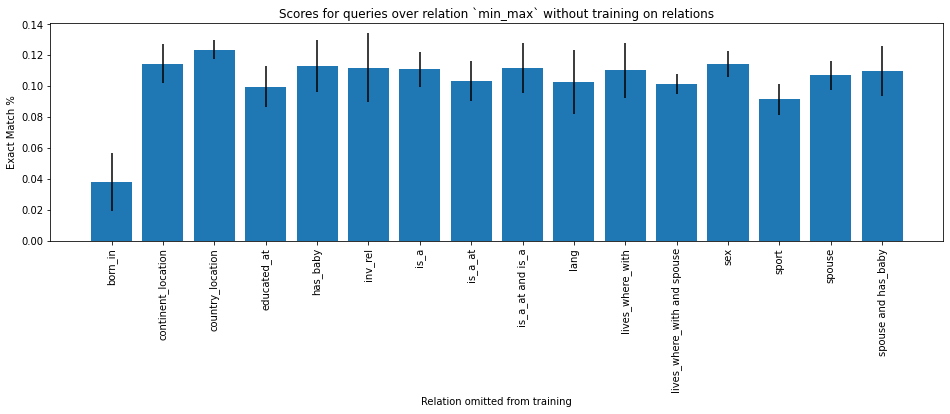

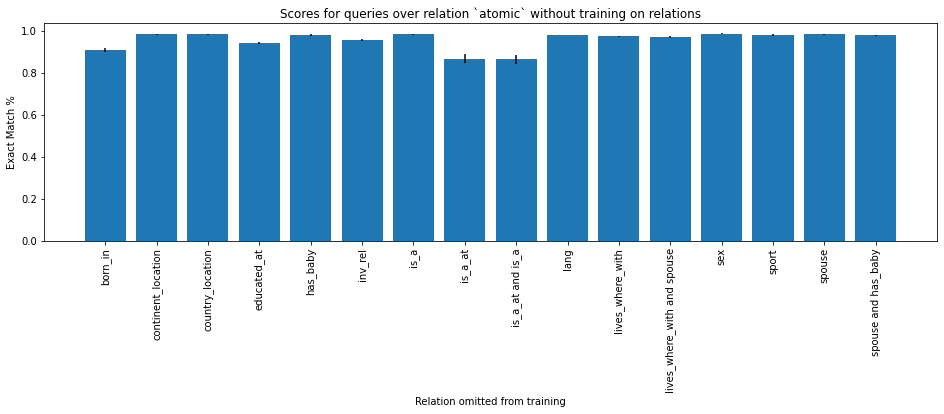

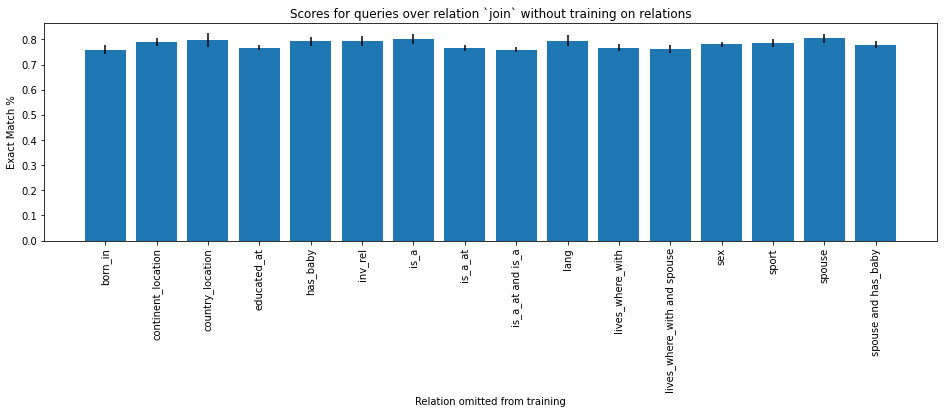

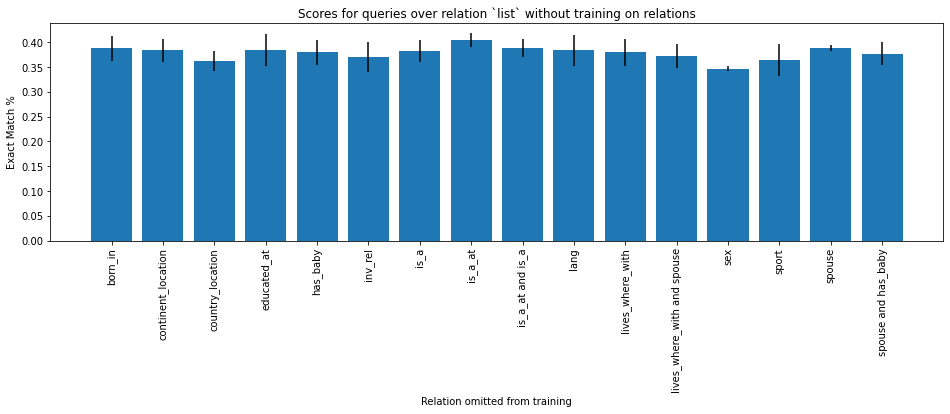

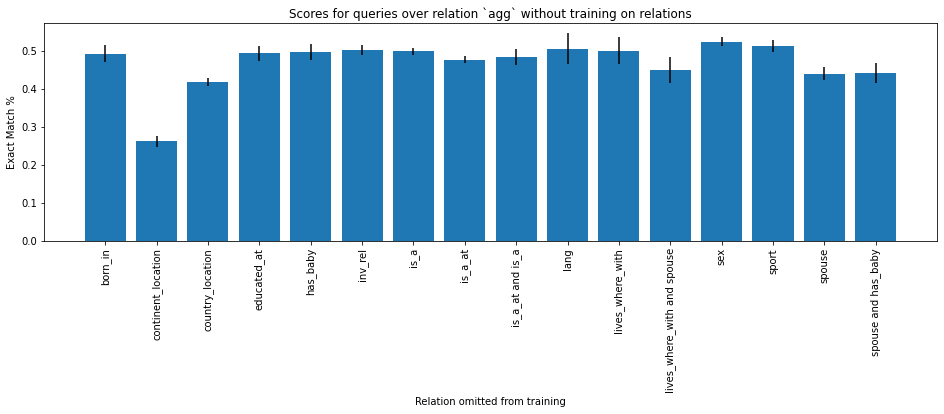

In [138]:
for col in breakdown_cols:
    means = breakdown[col]["mean"].T["t5-base"]["50"]
    std = breakdown[col]["std"].T["t5-base"]["50"]
    plt.figure(figsize=(16,4))
    plt.xticks(rotation=90)

    plt.title("Scores for queries over relation `{}` without training on relations".format(col.replace("breakdown_","")))
    plt.xlabel("Relation omitted from training")
    plt.ylabel("Exact Match %")
    plt.bar([i.replace('.',' and ') for i in means.index], means, yerr=std)
    plt.show()